# Titanic: Machine learning from disaster

The [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) is a Kaggle competition in which the objective of this competition is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. This type of machine learning is called [classification](https://en.wikipedia.org/wiki/Statistical_classification). More specifically, since there are only two different states we are classifying (survived or not survived), it is called [binary classification](https://en.wikipedia.org/wiki/Binary_classification).

This notebook covers:

* How to import and check the data.
* Exploratory data analysis.
* Feature engineering - Create new features from the existing data.
* Model selection: Try a variety of models to improve performance.
* Hyperparameter optimization: Optimize the settings within each particular machine learning model.

# Import and check data

In [1]:
# Import modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from time import time

mpl.rcParams.update({'font.size': 13})

In [2]:
# Import training and test sets
folder = './'
# folder = '/kaggle/input/titanic/'

train = pd.read_csv(folder + 'train.csv')
train_shape = train.shape

test = pd.read_csv(folder + 'test.csv')
test_shape = test.shape

# Target column
target = 'survived'

# Convert columns names to lowercase
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [3]:
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The columns of this DataFrame are:

* `passengerid` - Unique identifier of each passenger (used for submissions).
* `survived` - Whether the passenger survived or not (0=No, 1=Yes).
* `pclass` - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd).
* `name` - Name of the passenger.
* `sex` - The passenger's sex.
* `age` - The passenger's age in years.
* `sibsp` - The number of siblings or spouses the passenger had aboard the Titanic.
* `parch` - The number of parents or children the passenger had aboard the Titanic.
* `ticket` - The passenger's ticket number.
* `fare` - The fare the passenger paid.
* `cabin` - The passenger's cabin number.
* `embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton).

# Exploratory data analysis

Lets now look at the data types of the columns and the number of missing values.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         417 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The data types of the columns seem to be correct. The columns `age` and `cabin` of both datasets have missing values, and the column `fare` of the test set has only one missing value. Since most learning algorithms do not handle missing values, we will need to sort those if we want to use some of these columns. Now let's look at the number of unique values of each column of the training set.

In [6]:
train.apply(lambda col: len(col.unique()))

passengerid    891
survived         2
pclass           3
name           891
sex              2
age             89
sibsp            7
parch            7
ticket         681
fare           248
cabin          148
embarked         4
dtype: int64

We will first focus on the columns `pclass`, `sex`, `sibsp`, `parch`, `fare` and `embarked`. Since, most of these columns do not have many unique values and missing values, they might not require much processing.

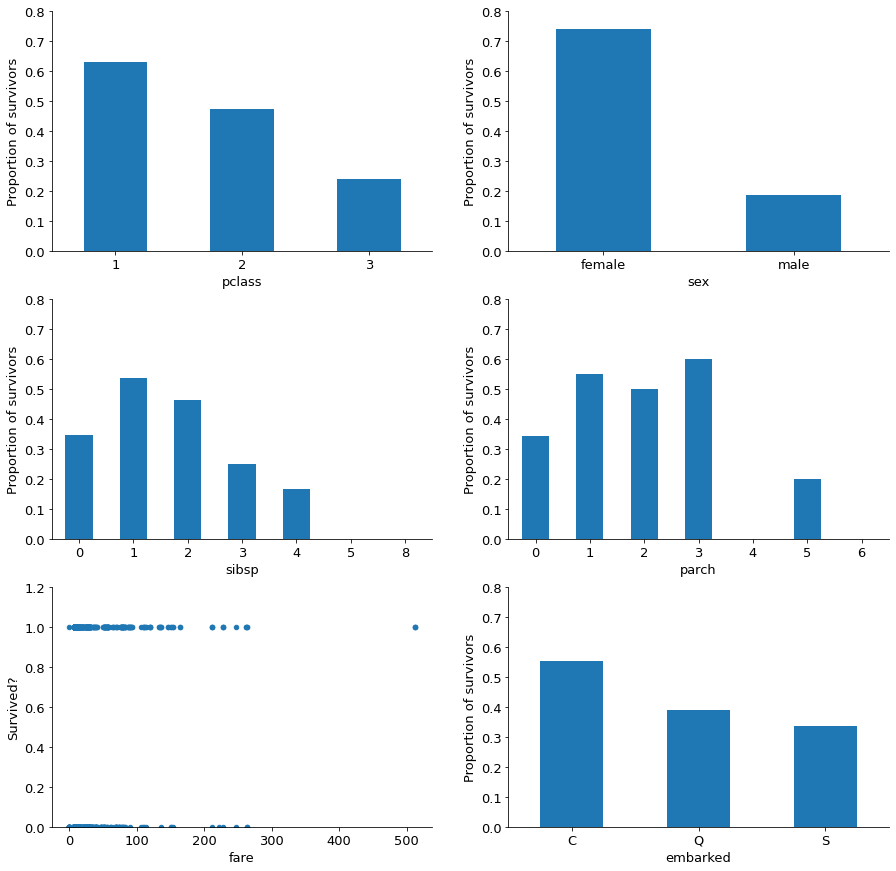

In [7]:
def set_spines(ax=None):
    '''Sets the box outline around the specified axis.'''

    if ax == None: ax = plt.gca()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig, axs = plt.subplots(3, 2, figsize=(15,15))
train.pivot_table(index='pclass',values='survived')['survived'].plot.bar(ax=axs[0,0])
train.pivot_table(index='sex',values='survived')['survived'].plot.bar(ax=axs[0,1])
train.pivot_table(index='sibsp',values='survived')['survived'].plot.bar(ax=axs[1,0])
train.pivot_table(index='parch',values='survived')['survived'].plot.bar(ax=axs[1,1])
train.plot.scatter(x='fare', y='survived', ax=axs[2,0]);
train.pivot_table(index='embarked',values='survived')['survived'].plot.bar(ax=axs[2,1])

for ax in axs.flatten():
    ax.tick_params(rotation=0)
    ax.set_ylabel('Proportion of survivors')
    set_spines(ax)
    ax.set_ylim([0, 0.8])

axs[2,0].set_ylabel('Survived?')
axs[2,0].set_ylim([0, 1.2]);

We can observe that:

* Passengers with upper-class tickets had better chances of survival than those without.
* Females survived in much higher proportions than males. This feature seems to have the highest correlation with the chances of survival.
* Passengers that were alone or had a lot of siblings or spouses were less likely to survive. A similar conclusion applies to the number of parents or children.
* The correlation between the fare and the chances of survival does not seem to be significant, and so we will drop this column.
* The port where the passenger embarked seems to influence the chances of survival.

In [8]:
# Drop fare column
train.drop('fare', axis=1, inplace=True)
test.drop('fare', axis=1, inplace=True)

The columns `pclass`, `sex` and `embarked` are categorical features. Although the column `pclass` is numeric, there is not a numeric relationship between the different values. For instance, class 3 is not the triple of class 1. Most machine learning algorithms cannot understand text labels, and so we have to convert our values into numbers. The pandas function [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) turns each categorical feature into a series of zeros and ones, which makes them a lot easier to quantify and compare.

In [9]:
def check_features_list(features):
    '''Checks that the features variable is a list.'''

    if type(features) == str:
        features = [features]
    
    return features

def convert_categorical_features(df, cat_features):
    '''Convert specified features to dummy variables.'''

    if len(cat_features) == 0:
        return df

    # Check that cat_features is a list
    cat_features = check_features_list(cat_features)

    # Convert the specified features
    for feature in cat_features:

        dummies = pd.get_dummies(df[feature], prefix=feature)

        df = pd.concat([df,dummies], axis=1)

    # Drop original features
    df.drop(cat_features, axis=1, inplace=True)

    return df

We will start by using a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier to predict if the passengers survived or not. This project uses the Python machine learning library [Scikit-learn](https://scikit-learn.org/), which is an open-source library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities. The steps to fit and evaluate our machine learning model are:

* Instantiate the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model
* Fit the model to the training data
* Use the model to make predictions
* Evaluate the accuracy of the predictions

We can’t use the test set to evaluate the predictions because it does not have the column `survived`. We would need to submit to Kaggle every time we wanted to assess the accuracy of the predictions. We could fit and predict using the entire training dataset, but this would likely overestimate the accuracy since our model would perform worse on unseen data. Instead, we can use a technique called cross-validation to train and test our model on different splits of our data, and then average the accuracy scores. We will be using the [k-fold cross-validation method](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation), in which the original sample is randomly partitioned into *k* equal sized subsamples. Of the *k* subsamples, a single subsample is retained as the validation data for testing the model, and the remaining *k* − 1 subsamples are used as training data. The cross-validation process is then repeated *k* times, with each of the *k* subsamples used exactly once as the validation data. The *k* results can then be averaged to produce a single estimation. We will use Scikit-learn function [model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). This function can use different cross-validation methods and scoring types, but it defaults to k-fold validation and accuracy scores for the input types we will use.

In [10]:
def copy_convert_dataset(df, cat_features=[], num_features=[], copy_target=True):
    '''Creates a copy of the dataset with the specified features and converts categorical features to dummy variables.'''
    
    # Check that the features variables are lists
    cat_features = check_features_list(cat_features)
    num_features = check_features_list(num_features)

    # Create a copy of the DataFrame with the specified features and target
    cols = cat_features + num_features
    if copy_target != False: cols = cols + [target]

    df_c = df[cols].copy()

    # Convert categorical features to dummy variables
    df_c = convert_categorical_features(df_c, cat_features)

    return df_c

def evaluate_lr_model(df, cat_features=[], num_features=[]):
    '''Evaluates the accuracy of the logistic regression classifier using 5-fold cross-validation.'''

    # Create a copy of df with the specified features and convert categorical features to dummy variables
    df_c = copy_convert_dataset(df, cat_features, num_features)

    # Evaluate accuracy using 5-fold cross-validation
    accuracy = cross_val_score(lr, df_c.loc[:,df_c.columns != target], df_c[target], cv=5).mean()

    return accuracy

We will first evaluate the influence of each feature separately, and after we will combine them all.

In [11]:
# Initialize the logistic regression classifier
lr = LogisticRegression()

# Categorical features
cat_features = ['pclass','sex','embarked']

for feature in cat_features:

    accuracy = evaluate_lr_model(train, cat_features=feature)
    print('{}: {:.2f}%'.format(feature, accuracy*100))
    
# Numerical features
num_features = ['sibsp','parch']

for feature in num_features:

    accuracy = evaluate_lr_model(train, num_features=feature)
    print('{}: {:.2f}%'.format(feature, accuracy*100))

pclass: 66.56%
sex: 78.67%
embarked: 63.64%
sibsp: 61.62%
parch: 60.72%


As expected, the model using the feature `sex`, which seemed to have the highest correlation with the chances of survival, has the highest accuracy (78.67%). Now we will combine all the five features.

In [12]:
accuracy = evaluate_lr_model(train, cat_features, num_features)
print('{}: {:.2f}%'.format(cat_features + num_features, accuracy*100))

['pclass', 'sex', 'embarked', 'sibsp', 'parch']: 78.90%


The accuracy of the model using the features `pclass`, `sex`, `embarked`, `sibsp` and `parch` was 78.90%. Now we will predict which passengers of the test set survived.

In [13]:
def predict_test(model, train_c, test_c, filenamne):
    '''Generates the predictions for the test set and writes them to file.'''

    # Get the features
    features = train_c.columns.to_list()
    features.remove(target)

    # Fit the model to the training data set
    model.fit(train_c[features], train_c[target])

    # Predict using the test set
    predictions = model.predict(test_c[features])

    # Write predictions to file
    submission = pd.DataFrame({"PassengerId":test["passengerid"],"Survived":predictions})
    submission.to_csv(filenamne, index=False)

# Create a copy of the training and test datasets with the selected features and convert categorical features to dummy
# variables
train_c = copy_convert_dataset(train, cat_features, num_features)
test_c = copy_convert_dataset(test, cat_features, num_features, False)

# Generate the predictions and write them to file
predict_test(lr, train_c, test_c, 'submission_1.csv')

The results were submitted to Kaggle on 9 December 2020, and their accuracy was 76.79%. This accuracy scored 11,104th out of 20,824 (Top 54%).

# Feature engineering

Feature engineering is the process of transforming raw data into features that better represent the underlying problem and enable more accurate predictive models. One common way to engineer a feature is using a technique called binning. Binning is when you take a continuous feature, like the age of a passenger, and separate it into several ranges (or 'bins'), turning it into a categorical variable. This can be useful when there are patterns in the data that are nonlinear and you're using a linear model like logistic regression. Let’s group the `age` column into the following age groups:

Age group | Age interval
--- | ---
Infant | 0-5
Child  | 5-12
Teenager | 12-18
Adult | 18-60
Senior | 60+

Since there are some missing values, we will create an additional category name `missing`.

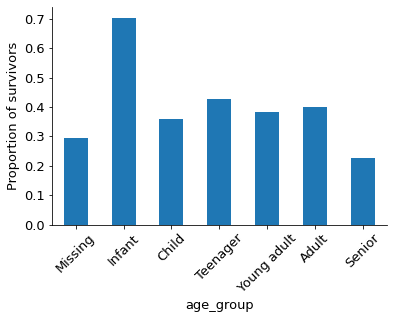

In [14]:
def group_age(age):

    age = age.fillna(-0.5)
    
    age_intervals = [-1,0,5,12,18,35,60,150]
    age_group = ['Missing','Infant','Child','Teenager','Young adult','Adult','Senior']

    return pd.cut(age, age_intervals, labels=age_group)

train['age_group'] = group_age(train['age'])

train.pivot_table(index='age_group',values='survived')['survived'].plot.bar(rot=45, ylabel='Proportion of survivors')
set_spines()

We can see that the vast majority of infants survived the shipwreck. Let’s calculate the accuracy of our model with the additional feature `age_group`.

In [15]:
cat_features = ['pclass','sex','embarked','age_group']

accuracy = evaluate_lr_model(train, cat_features, num_features)
print('{}: {:.2f}%'.format(cat_features + num_features, accuracy*100))

['pclass', 'sex', 'embarked', 'age_group', 'sibsp', 'parch']: 81.59%


Our accuracy increased from 78.90% to 81.59%. Another way to engineer features is by extracting data from text columns. Let's look at a random sample of the column `name`.

In [16]:
train['name'].sample(10)

419         Van Impe, Miss. Catharina
329      Hippach, Miss. Jean Gertrude
72               Hood, Mr. Ambrose Jr
519               Pavlovic, Mr. Stefo
719      Johnson, Mr. Malkolm Joackim
563                 Simmons, Mr. John
579               Jussila, Mr. Eiriik
723           Hodges, Mr. Henry Price
245       Minahan, Dr. William Edward
220    Sunderland, Mr. Victor Francis
Name: name, dtype: object

The title of each name might be useful information. We will create a new column with this.

In [17]:
titles = train["name"].str.extract(' ([A-Za-z]+)\.', expand=False)
titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

We have too many unique values, which might lead to overfitting. We will group these titles into the categories `Mr`, `Mrs`, `Master`, `Miss`, `Officer` and `Royalty`.

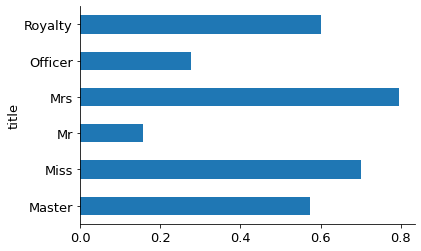

In [18]:
titles_map = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

def extract_title(name):
    '''Extracts the title from the passenger name.'''

    return name.str.extract(' ([A-Za-z]+)\.', expand=False).map(titles_map)

train["title"] = extract_title(train['name'])

train.pivot_table(index='title',values='survived')['survived'].plot.barh()
set_spines()

We can see that the majority of men that were not royalty did not survive the shipwreck. Let’s calculate the accuracy of our model with the additional feature `title`.

In [19]:
cat_features = ['pclass','sex','embarked','age_group','title']

accuracy = evaluate_lr_model(train, cat_features, num_features)
print('{}: {:.2f}%'.format(cat_features + num_features, accuracy*100))

['pclass', 'sex', 'embarked', 'age_group', 'title', 'sibsp', 'parch']: 82.38%


Our accuracy increased from 81.59% to 82.38%. Now we will predict which passengers of the test set survived.

In [20]:
test['age_group'] = group_age(test['age'])
test["title"] = extract_title(test['name'])

train_c = copy_convert_dataset(train, cat_features, num_features)
test_c = copy_convert_dataset(test, cat_features, num_features, False)

predict_test(lr, train_c, test_c, 'submission_2.csv')

The results were submitted to Kaggle on 9 December 2020, and their accuracy was 78.94%. This accuracy scored 2,127th out of 20,854 (Top 11%), which represented moving up 8977 positions on the leaderboard!

# Model selection

We can also try different machine learning models to improve performance. Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data. We will use the Scikit-learn library to compare the performance of the following algorithms:

* [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) - Logistic regression classifier.
* [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) - Decision tree classifier.
* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - Random forest classifier.

In [21]:
def evaluate_model(model, df):
    '''Evaluates the accuracy of the specified model using 5-fold cross-validation.'''

    accuracy = cross_val_score(model, df.loc[:,df.columns != target], df[target], cv=5).mean()

    return accuracy

models = {
    'Logistic regression':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(random_state=1),
    'Random forest':RandomForestClassifier(random_state=1)
}

for k, v in models.items():
    
    accuracy = evaluate_model(v, train_c)
    print('{}: {:.2f}%'.format(k, accuracy*100))

Logistic regression: 82.38%
Decision tree: 78.79%
Random forest: 79.80%


The logistic regression classifier has the highest accuracy, and hence there is no need to submit the predictions to Kaggle.

# Hyperparameter optimization

Finally, we can consider hyperparameter optimization to tune the performance of our machine learning models. This approach consists of optimizing the settings within each particular model.

In [22]:
# List of models and their hyperparameters
models = [
    {
     'name':'Logistic regression',
     'estimator':LogisticRegression(),
     'hyperparameters':{
         'solver': ['newton-cg', 'lbfgs', 'liblinear']
         }
    },
    {
     'name':'Decision tree',
     'estimator':DecisionTreeClassifier(random_state=1),
     'hyperparameters':{
         'criterion':['entropy','gini'],
         'splitter':['best','random'],
         'max_depth':range(4,10),
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4]
         }
    },    {
     'name':'RandomForestClassifier',
     'estimator':RandomForestClassifier(n_estimators=300, random_state=1),
     'hyperparameters':{
         'criterion':['entropy','gini'],
         'max_depth':range(4,9),
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4]
         }
    }
]

def tune_models(models, df):

    start = time()
    
    for model in models:

        print(model['name'])
        print('-' * len(model['name']))

        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=5)

        grid.fit(df.loc[:,df.columns != target], df[target])

        model['best_score'] = grid.best_score_
        model['best_params'] = grid.best_params_
        model['best_model'] = grid.best_estimator_

        print('Best accuracy: {:.2f}%'.format(model['best_score']*100))
        print('Best parameters: {}\n'.format(model['best_params']))

    end = time()

    print()
    print('Elapsed time: {:.2f}s'.format(end - start))

    return models

models = tune_models(models, train_c)

Logistic regression
-------------------
Best accuracy: 82.38%
Best parameters: {'solver': 'newton-cg'}

Decision tree
-------------
Best accuracy: 81.60%
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 4, 'splitter': 'best'}

RandomForestClassifier
----------------------
Best accuracy: 83.28%
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2}


Elapsed time: 200.37s


By using the random forest classifier, the accuracy increased from 82.38% to 83.28%. Now we will predict which passengers of the test set survived.

In [23]:
predict_test(models[2]['best_model'], train_c, test_c, 'submission_3.csv')

The results were submitted to Kaggle on 10 December 2020, and their accuracy was 78.23%. This accuracy scored 2,141th out of 21,052 (Top 11%), which represented moving down 14 positions on the leaderboard. Although the accuracy obtained using the cross-validation on the training test increased, the accuracy obtained on the predictions submitted to Kaggle decreased. Although this is not what we expected, it is possible, since our model is predicting using unseen data.

# Conclusions

This notebook uses machine learning models to predict which passengers survived the Titanic shipwreck. It explores how feature engineering, model selection, and hyperparameter optimization influences the accuracy of our model. The figure below shows the accuracy of our models obtained for these different stages. The accuracies were obtained using a cross-validation method on the training set and by submitting the test set's predictions to Kaggle.

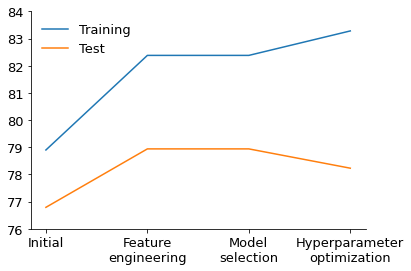

In [24]:
plt.plot([78.90, 82.38, 82.38, 83.28])
plt.plot([76.79, 78.94, 78.94, 78.23])
plt.xticks([0,1,2,3], ['Initial','Feature\nengineering','Model\nselection','Hyperparameter\noptimization'])
plt.legend(['Training', 'Test'], frameon=False)
plt.ylim([76,84])
set_spines()

To further improve our models we can:

* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use different models such as support vector machines, stochastic gradient descent or perceptron linear models.

Also, there are several other excellent notebooks related to this competition. Thanks for reading my notebook and any comments and suggestions are very welcome.